# Create initial Eocene ocean temperature and salinity fields

In [1]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc
import os
import shutil

# locations for present-day reference file for correct metadata and output directory for new files
referenceFile = '/home/users/ssteinig/pmip4_gws/gc31/ancil_input_data/ocean/initial/EN4_v1.1.1995_2014.monthlymean_eORCA1T_NEMO_L75_orig.nc'
outputDir = '/home/users/ssteinig/HadGEM3_Eocene_setup/eocene_output_data/ocean/initial'

## idealised temperature distribution
The DeepMIP-Eocene experimental design paper (Lunt et al., 2017), suggests the following equation to generate the initial horizontal and vertical temperature distribution:

$$   T[^{\circ}C] =
\begin{cases}
  \left( \frac{5000-z}{5000} \times 25 \times cos \:\phi \right) + 15 & \text{if z $\leq$ 5000 m}\\
  15 & \text{if z > 5000 m} \\
\end{cases} 
\tag{1}
$$

Experience from the first DeepMIP-Eocene phase shows that this overestimnates the subsurface ocean heat, which resulted in extended spin-up durations to slowly remove this excess heat from the ocean (several thousand years). I therefore test a modified version of the default equation which is given by:

$$   T[^{\circ}C] =
\begin{cases}
  \left( \left(\frac{2500-z}{2500}\right)^6 \times T_{upper}  \times cos^2 \:\phi \right) + T_{deep} & \text{if z $\leq$ 2500 m}\\
  T_{deep} & \text{if z > 2500 m}\\
\end{cases} 
\tag{2}
$$

where $\phi$ is latitude and z is depth below the surface. $T_{upper}$ and $T_{deep}$ are scaling parameters that only depend on the global mean surface temperature (GMST). The relation between the GMST and the deep ocean temperatures is taken from a large ensemble of HadCM3BL simulations across the Phanerozoic (Fig. 11 in Valdes et al., 2021) and can be expressed as:
$$
T_{deep} = \frac{GMST - 15.4}{0.76}
\tag{3}
$$

With this, we can numerically solve for $T_{upper}$. 

Assumption:  We can calculate $T_{deep}$ and need to chose $T_{upper}$ so that at the surface (i.e. z=0), Eq. (2) reproduces the initial GMST value when averaged over the globe, i.e. given (for z=0 and weights=$cos \:\phi $):
$$
T[^{\circ}C] = T_{upper} \times weights^2 + T_{deep}
\tag{4}
$$

$$
GMST = \frac{\sum weights \times T}{\sum weights}
\tag{5}
$$

will give:
$$
T_{upper} =\frac{GMST - T_{deep}}{\frac{\sum weights \times weights^2}{\sum weights}} \approx \frac{GMST - T_{deep}}{0.67}
\tag{6}
$$

## NEMO implementation
NEMO needs monthly mean 3D fields of temperature and salinity to initilise the ocean. Eocene temperatures are produced in the following way:
1. Copy modern reference file (for correct metadata).
2. Loop over each latitude and longitude and calculate the local vertical temperature profile. Necesseary due to curvilinear grid in NEMO. This could be simpliefied to save some computation time for more regular grids.
3. Salinities are set to a single global value of 34.7.
4. Save new temperature and salinity field to disk


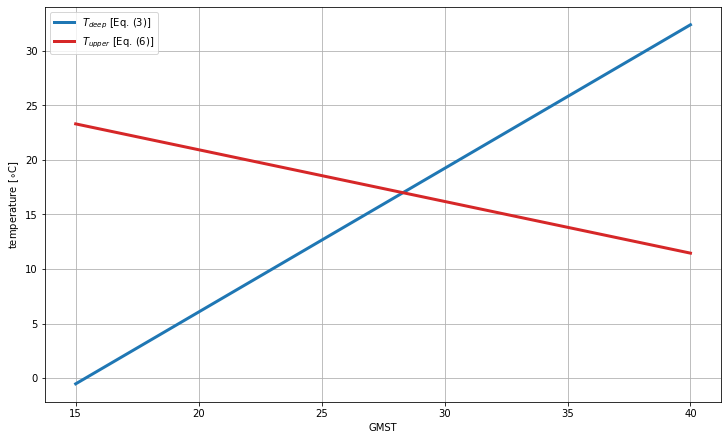

In [17]:
# let's quickly plot the results
lats = np.arange(-90, 91, 0.1)
weights = np.cos(np.radians(lats))

# equations (3) and (6) from above
def calc_T_deep(GMST):
    return (GMST - 15.4) / 0.76

def calc_T_upper(gmst, T_deep):
    weighted_sum = np.sum(weights * weights**2)
    average_weight = np.sum(weights)
    T_upper = (gmst - T_deep) / (weighted_sum / average_weight)
    return T_upper
    
# generate results for GMST's between 0 to 40
GMST_values = np.linspace(15, 40, 400)

# compute T_deep for each GMST value
T_deep_values = calc_T_deep(GMST_values)

# compute T_upper for each GMST value
T_upper_values = calc_T_upper(GMST_values, T_deep_values)

# Plotting
figrad, axs = plt.subplots(1, 1, figsize=(10,6), constrained_layout=True)

axs.plot(GMST_values, T_deep_values, label=r'$T_{deep}$ [Eq. (3)]', color='tab:blue', linewidth=3)
axs.plot(GMST_values, T_upper_values, label=r'$T_{upper}$ [Eq. (6)]', color='tab:red', linewidth=3)

axs.set_xlabel('GMST')
axs.set_ylabel('temperature [$\circ}$C]')

axs.legend()
axs.grid(True)

plt.savefig(outputDir + '/T_deep_and_T_upper_vs_GMST.pdf', format='pdf')

plt.show()




## apply equations to NEMO initial temperatures

In [4]:
# create output directory
if not os.path.exists(outputDir):
    os.makedirs(outputDir)
# copy reference file
shutil.copy2(referenceFile, outputDir + '/TS_monthlymean_eORCA1T_NEMO_L75.eocene1x.nc')
shutil.copy2(referenceFile, outputDir + '/TS_monthlymean_eORCA1T_NEMO_L75.eocene2x.nc')
shutil.copy2(referenceFile, outputDir + '/TS_monthlymean_eORCA1T_NEMO_L75.eocene3x.nc')
shutil.copy2(referenceFile, outputDir + '/TS_monthlymean_eORCA1T_NEMO_L75.eocene4x.nc')
shutil.copy2(referenceFile, outputDir + '/TS_monthlymean_eORCA1T_NEMO_L75.GMD.nc')

'/home/users/ssteinig/HadGEM3_Eocene_setup/eocene_output_data/ocean/initial/TS_monthlymean_eORCA1T_NEMO_L75.GMD.nc'

In [5]:
# load original modern day data for overview
TS_old = xr.open_dataset(referenceFile)
TS_old

<xarray.Dataset>
Dimensions:      (depth: 75, time: 12, y: 332, x: 362)
Coordinates:
  * depth        (depth) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time         (time) object 1976-01-16 00:00:00 ... 1976-12-16 00:00:00
    nav_lon      (y, x) float32 ...
    nav_lat      (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables:
    temperature  (time, depth, y, x) float32 ...
    salinity     (time, depth, y, x) float32 ...
Attributes:
    file_name:  /project/nemo/CMA_clim/regridded/EN4_v1.1/EN4_v1.1.1995_2014....

In [6]:
# version 1: let's start with the original DeepMIP equation for reference
# i.e. modify T+S climatologies following Lunt et al. (2017)

# convert datatset to array for easy looping
T_new = TS_old['temperature'].copy()
S_new = TS_old['salinity'].copy()
depth = TS_old['depth'].copy()
nav_lat = TS_old['nav_lat'].copy()

# fill fields with bottom/homogeneous value
T_new.loc[:] = 15.0 # temperature
S_new.loc[:] = 34.7 # salinity

# temperatures decrease with depth until 'depthCutoff' reached
depthCutoff = 5000.
shallowIdx = np.where(depth <= depthCutoff)
shallowWeights = (depthCutoff-depth[shallowIdx[0]]) / depthCutoff

#loop over all gridboxes to set new values above 'depthCutoff'
for ii in range(len(TS_old['x'])):
    print(str(ii) + '/' + str(len(TS_old['x'])))
    for jj in range(len(TS_old['y'])):
         T_new[:,shallowIdx[0],jj,ii] = ( shallowWeights * 25 * np.cos(np.radians(nav_lat[jj,ii])) ) + 15.0

TS_gmd = TS_old.copy()
TS_gmd['temperature'] = T_new.copy()
TS_gmd['salinity'] = S_new.copy()


0/362
1/362
2/362
3/362
4/362
5/362
6/362
7/362
8/362
9/362
10/362
11/362
12/362
13/362
14/362
15/362
16/362
17/362
18/362
19/362
20/362
21/362
22/362
23/362
24/362
25/362
26/362
27/362
28/362
29/362
30/362
31/362
32/362
33/362
34/362
35/362
36/362
37/362
38/362
39/362
40/362
41/362
42/362
43/362
44/362
45/362
46/362
47/362
48/362
49/362
50/362
51/362
52/362
53/362
54/362
55/362
56/362
57/362
58/362
59/362
60/362
61/362
62/362
63/362
64/362
65/362
66/362
67/362
68/362
69/362
70/362
71/362
72/362
73/362
74/362
75/362
76/362
77/362
78/362
79/362
80/362
81/362
82/362
83/362
84/362
85/362
86/362
87/362
88/362
89/362
90/362
91/362
92/362
93/362
94/362
95/362
96/362
97/362
98/362
99/362
100/362
101/362
102/362
103/362
104/362
105/362
106/362
107/362
108/362
109/362
110/362
111/362
112/362
113/362
114/362
115/362
116/362
117/362
118/362
119/362
120/362
121/362
122/362
123/362
124/362
125/362
126/362
127/362
128/362
129/362
130/362
131/362
132/362
133/362
134/362
135/362
136/362
137/362
138/36

In [7]:
# new Eocene 1x: modify T+S climatologies following modified equation above, i.e.:
#                - faster cooling with depth
#                - deep ocean temperatures for 1x Eocene simulation set to 10 degc 
#                - cos**2 latitudinal dependence
#                - global mean surface temperature scaled to 23 degC
#            
#                GMST: 23.0
#                rationale: CESM2 with similar ECS as HadGEM3 simulates 23 degC GMST for 1x Eocene (Zhu et al., 2021)

T_deep = calc_T_deep(23.0)
T_upper = calc_T_upper(23.0, T_deep)

print("T_deep for Eocene 1x: ", T_deep)
print("T_upper for Eocene 1x: ", T_upper)

# convert datatset to array for easy looping
T_new = TS_old['temperature'].copy()
S_new = TS_old['salinity'].copy()
depth = TS_old['depth'].copy()
nav_lat = TS_old['nav_lat'].copy()

# fill fields with bottom/homogeneous value
T_new.loc[:] = T_deep # temperature
S_new.loc[:] = 34.7 # salinity

# temperatures decrease with depth until 'depthCutoff' reached
depthCutoff = 2500.
shallowIdx = np.where(depth <= depthCutoff)
shallowWeights = (depthCutoff-depth[shallowIdx[0]]) / depthCutoff

#loop over all gridboxes to set new values above 'depthCutoff'
for ii in range(len(TS_old['x'])):
    print(str(ii) + '/' + str(len(TS_old['x'])))
    for jj in range(len(TS_old['y'])):
         T_new[:,shallowIdx[0],jj,ii] = ( shallowWeights ** 6 * T_upper * np.cos(np.radians(nav_lat[jj,ii])) ** 2 ) + T_deep

TS_eocene1x = TS_old.copy()
TS_eocene1x['temperature'] = T_new.copy()
TS_eocene1x['salinity'] = S_new.copy()

T_deep for Eocene 1x:  10.0
T_upper for Eocene 1x:  19.498658846333903
0/362
1/362
2/362
3/362
4/362
5/362
6/362
7/362
8/362
9/362
10/362
11/362
12/362
13/362
14/362
15/362
16/362
17/362
18/362
19/362
20/362
21/362
22/362
23/362
24/362
25/362
26/362
27/362
28/362
29/362
30/362
31/362
32/362
33/362
34/362
35/362
36/362
37/362
38/362
39/362
40/362
41/362
42/362
43/362
44/362
45/362
46/362
47/362
48/362
49/362
50/362
51/362
52/362
53/362
54/362
55/362
56/362
57/362
58/362
59/362
60/362
61/362
62/362
63/362
64/362
65/362
66/362
67/362
68/362
69/362
70/362
71/362
72/362
73/362
74/362
75/362
76/362
77/362
78/362
79/362
80/362
81/362
82/362
83/362
84/362
85/362
86/362
87/362
88/362
89/362
90/362
91/362
92/362
93/362
94/362
95/362
96/362
97/362
98/362
99/362
100/362
101/362
102/362
103/362
104/362
105/362
106/362
107/362
108/362
109/362
110/362
111/362
112/362
113/362
114/362
115/362
116/362
117/362
118/362
119/362
120/362
121/362
122/362
123/362
124/362
125/362
126/362
127/362
128/362
129/362

In [8]:
# new Eocene 2x: modify T+S climatologies following modified equation above
#
#                GMST: 28.5
#                rationale: 1x GMST of 23 degC + ECS of 5.5 degC

T_deep = calc_T_deep(28.5)
T_upper = calc_T_upper(28.5, T_deep)

print("T_deep for Eocene 2x: ", T_deep)
print("T_upper for Eocene 2x: ", T_upper)

# convert datatset to array for easy looping
T_new = TS_old['temperature'].copy()
S_new = TS_old['salinity'].copy()
depth = TS_old['depth'].copy()
nav_lat = TS_old['nav_lat'].copy()

# fill fields with bottom/homogeneous value
T_new.loc[:] = T_deep # temperature
S_new.loc[:] = 34.7 # salinity

# temperatures decrease with depth until 'depthCutoff' reached
depthCutoff = 2500.
shallowIdx = np.where(depth <= depthCutoff)
shallowWeights = (depthCutoff-depth[shallowIdx[0]]) / depthCutoff

#loop over all gridboxes to set new values above 'depthCutoff'
for ii in range(len(TS_old['x'])):
    print(str(ii) + '/' + str(len(TS_old['x'])))
    for jj in range(len(TS_old['y'])):
         T_new[:,shallowIdx[0],jj,ii] = ( shallowWeights ** 6 * T_upper * np.cos(np.radians(nav_lat[jj,ii])) ** 2 ) + T_deep

TS_eocene2x = TS_old.copy()
TS_eocene2x['temperature'] = T_new.copy()
TS_eocene2x['salinity'] = S_new.copy()

T_deep for Eocene 2x:  17.236842105263158
T_upper for Eocene 2x:  16.893574870912772
0/362
1/362
2/362
3/362
4/362
5/362
6/362
7/362
8/362
9/362
10/362
11/362
12/362
13/362
14/362
15/362
16/362
17/362
18/362
19/362
20/362
21/362
22/362
23/362
24/362
25/362
26/362
27/362
28/362
29/362
30/362
31/362
32/362
33/362
34/362
35/362
36/362
37/362
38/362
39/362
40/362
41/362
42/362
43/362
44/362
45/362
46/362
47/362
48/362
49/362
50/362
51/362
52/362
53/362
54/362
55/362
56/362
57/362
58/362
59/362
60/362
61/362
62/362
63/362
64/362
65/362
66/362
67/362
68/362
69/362
70/362
71/362
72/362
73/362
74/362
75/362
76/362
77/362
78/362
79/362
80/362
81/362
82/362
83/362
84/362
85/362
86/362
87/362
88/362
89/362
90/362
91/362
92/362
93/362
94/362
95/362
96/362
97/362
98/362
99/362
100/362
101/362
102/362
103/362
104/362
105/362
106/362
107/362
108/362
109/362
110/362
111/362
112/362
113/362
114/362
115/362
116/362
117/362
118/362
119/362
120/362
121/362
122/362
123/362
124/362
125/362
126/362
127/362
1

In [9]:
# new Eocene 3x: modify T+S climatologies following modified equation above
#
#                GMST: 31.8
#                rationale: with ECS of 5.5 degC would expect ln(840/560) / ln(1120/560) * 5.5 = 3.2 degC GMST increase
#                           compared to 2x simulation

T_deep = calc_T_deep(31.8)
T_upper = calc_T_upper(31.8, T_deep)

print("T_deep for Eocene 3x: ", T_deep)
print("T_upper for Eocene 3x: ", T_upper)

# convert datatset to array for easy looping
T_new = TS_old['temperature'].copy()
S_new = TS_old['salinity'].copy()
depth = TS_old['depth'].copy()
nav_lat = TS_old['nav_lat'].copy()

# fill fields with bottom/homogeneous value
T_new.loc[:] = T_deep # temperature
S_new.loc[:] = 34.7 # salinity

# temperatures decrease with depth until 'depthCutoff' reached
depthCutoff = 2500.
shallowIdx = np.where(depth <= depthCutoff)
shallowWeights = (depthCutoff-depth[shallowIdx[0]]) / depthCutoff

#loop over all gridboxes to set new values above 'depthCutoff'
for ii in range(len(TS_old['x'])):
    print(str(ii) + '/' + str(len(TS_old['x'])))
    for jj in range(len(TS_old['y'])):
        # use latitude from curvilinear grid (lat depends on x and y)
        T_new[:,shallowIdx[0],jj,ii] = ( shallowWeights ** 6 * T_upper * np.cos(np.radians(nav_lat[jj,ii])) ** 2 ) + T_deep
            
TS_eocene3x = TS_old.copy()
TS_eocene3x['temperature'] = T_new.copy()
TS_eocene3x['salinity'] = S_new.copy()

T_deep for Eocene 3x:  21.57894736842105
T_upper for Eocene 3x:  15.3305244856601
0/362
1/362
2/362
3/362
4/362
5/362
6/362
7/362
8/362
9/362
10/362
11/362
12/362
13/362
14/362
15/362
16/362
17/362
18/362
19/362
20/362
21/362
22/362
23/362
24/362
25/362
26/362
27/362
28/362
29/362
30/362
31/362
32/362
33/362
34/362
35/362
36/362
37/362
38/362
39/362
40/362
41/362
42/362
43/362
44/362
45/362
46/362
47/362
48/362
49/362
50/362
51/362
52/362
53/362
54/362
55/362
56/362
57/362
58/362
59/362
60/362
61/362
62/362
63/362
64/362
65/362
66/362
67/362
68/362
69/362
70/362
71/362
72/362
73/362
74/362
75/362
76/362
77/362
78/362
79/362
80/362
81/362
82/362
83/362
84/362
85/362
86/362
87/362
88/362
89/362
90/362
91/362
92/362
93/362
94/362
95/362
96/362
97/362
98/362
99/362
100/362
101/362
102/362
103/362
104/362
105/362
106/362
107/362
108/362
109/362
110/362
111/362
112/362
113/362
114/362
115/362
116/362
117/362
118/362
119/362
120/362
121/362
122/362
123/362
124/362
125/362
126/362
127/362
128/

In [10]:
# new Eocene 4x: modify T+S climatologies following modified equation above
#
#                GMST: 34.0
#                rationale: with ECS of 5.5 degC would expect 5.5 degC GMST increase compared to 2x -> 34 degC GMST

T_deep = calc_T_deep(34.0)
T_upper = calc_T_upper(34.0, T_deep)

print("T_deep for Eocene 4x: ", T_deep)
print("T_upper for Eocene 4x: ", T_upper)

# convert datatset to array for easy looping
T_new = TS_old['temperature'].copy()
S_new = TS_old['salinity'].copy()
depth = TS_old['depth'].copy()
nav_lat = TS_old['nav_lat'].copy()

# fill fields with bottom/homogeneous value
T_new.loc[:] = T_deep # temperature
S_new.loc[:] = 34.7 # salinity

# temperatures decrease with depth until 'depthCutoff' reached
depthCutoff = 2500.
shallowIdx = np.where(depth <= depthCutoff)
shallowWeights = (depthCutoff-depth[shallowIdx[0]]) / depthCutoff

#loop over all gridboxes to set new values above 'depthCutoff'
for ii in range(len(TS_old['x'])):
    print(str(ii) + '/' + str(len(TS_old['x'])))
    for jj in range(len(TS_old['y'])):
        #use latitude from curvilinear grid (lat depends on x and y)
        T_new[:,shallowIdx[0],jj,ii] = ( shallowWeights ** 6 * T_upper * np.cos(np.radians(nav_lat[jj,ii])) ** 2 ) + T_deep
            
TS_eocene4x = TS_old.copy()
TS_eocene4x['temperature'] = T_new.copy()
TS_eocene4x['salinity'] = S_new.copy()

T_deep for Eocene 4x:  24.47368421052632
T_upper for Eocene 4x:  14.28849089549164
0/362
1/362
2/362
3/362
4/362
5/362
6/362
7/362
8/362
9/362
10/362
11/362
12/362
13/362
14/362
15/362
16/362
17/362
18/362
19/362
20/362
21/362
22/362
23/362
24/362
25/362
26/362
27/362
28/362
29/362
30/362
31/362
32/362
33/362
34/362
35/362
36/362
37/362
38/362
39/362
40/362
41/362
42/362
43/362
44/362
45/362
46/362
47/362
48/362
49/362
50/362
51/362
52/362
53/362
54/362
55/362
56/362
57/362
58/362
59/362
60/362
61/362
62/362
63/362
64/362
65/362
66/362
67/362
68/362
69/362
70/362
71/362
72/362
73/362
74/362
75/362
76/362
77/362
78/362
79/362
80/362
81/362
82/362
83/362
84/362
85/362
86/362
87/362
88/362
89/362
90/362
91/362
92/362
93/362
94/362
95/362
96/362
97/362
98/362
99/362
100/362
101/362
102/362
103/362
104/362
105/362
106/362
107/362
108/362
109/362
110/362
111/362
112/362
113/362
114/362
115/362
116/362
117/362
118/362
119/362
120/362
121/362
122/362
123/362
124/362
125/362
126/362
127/362
128

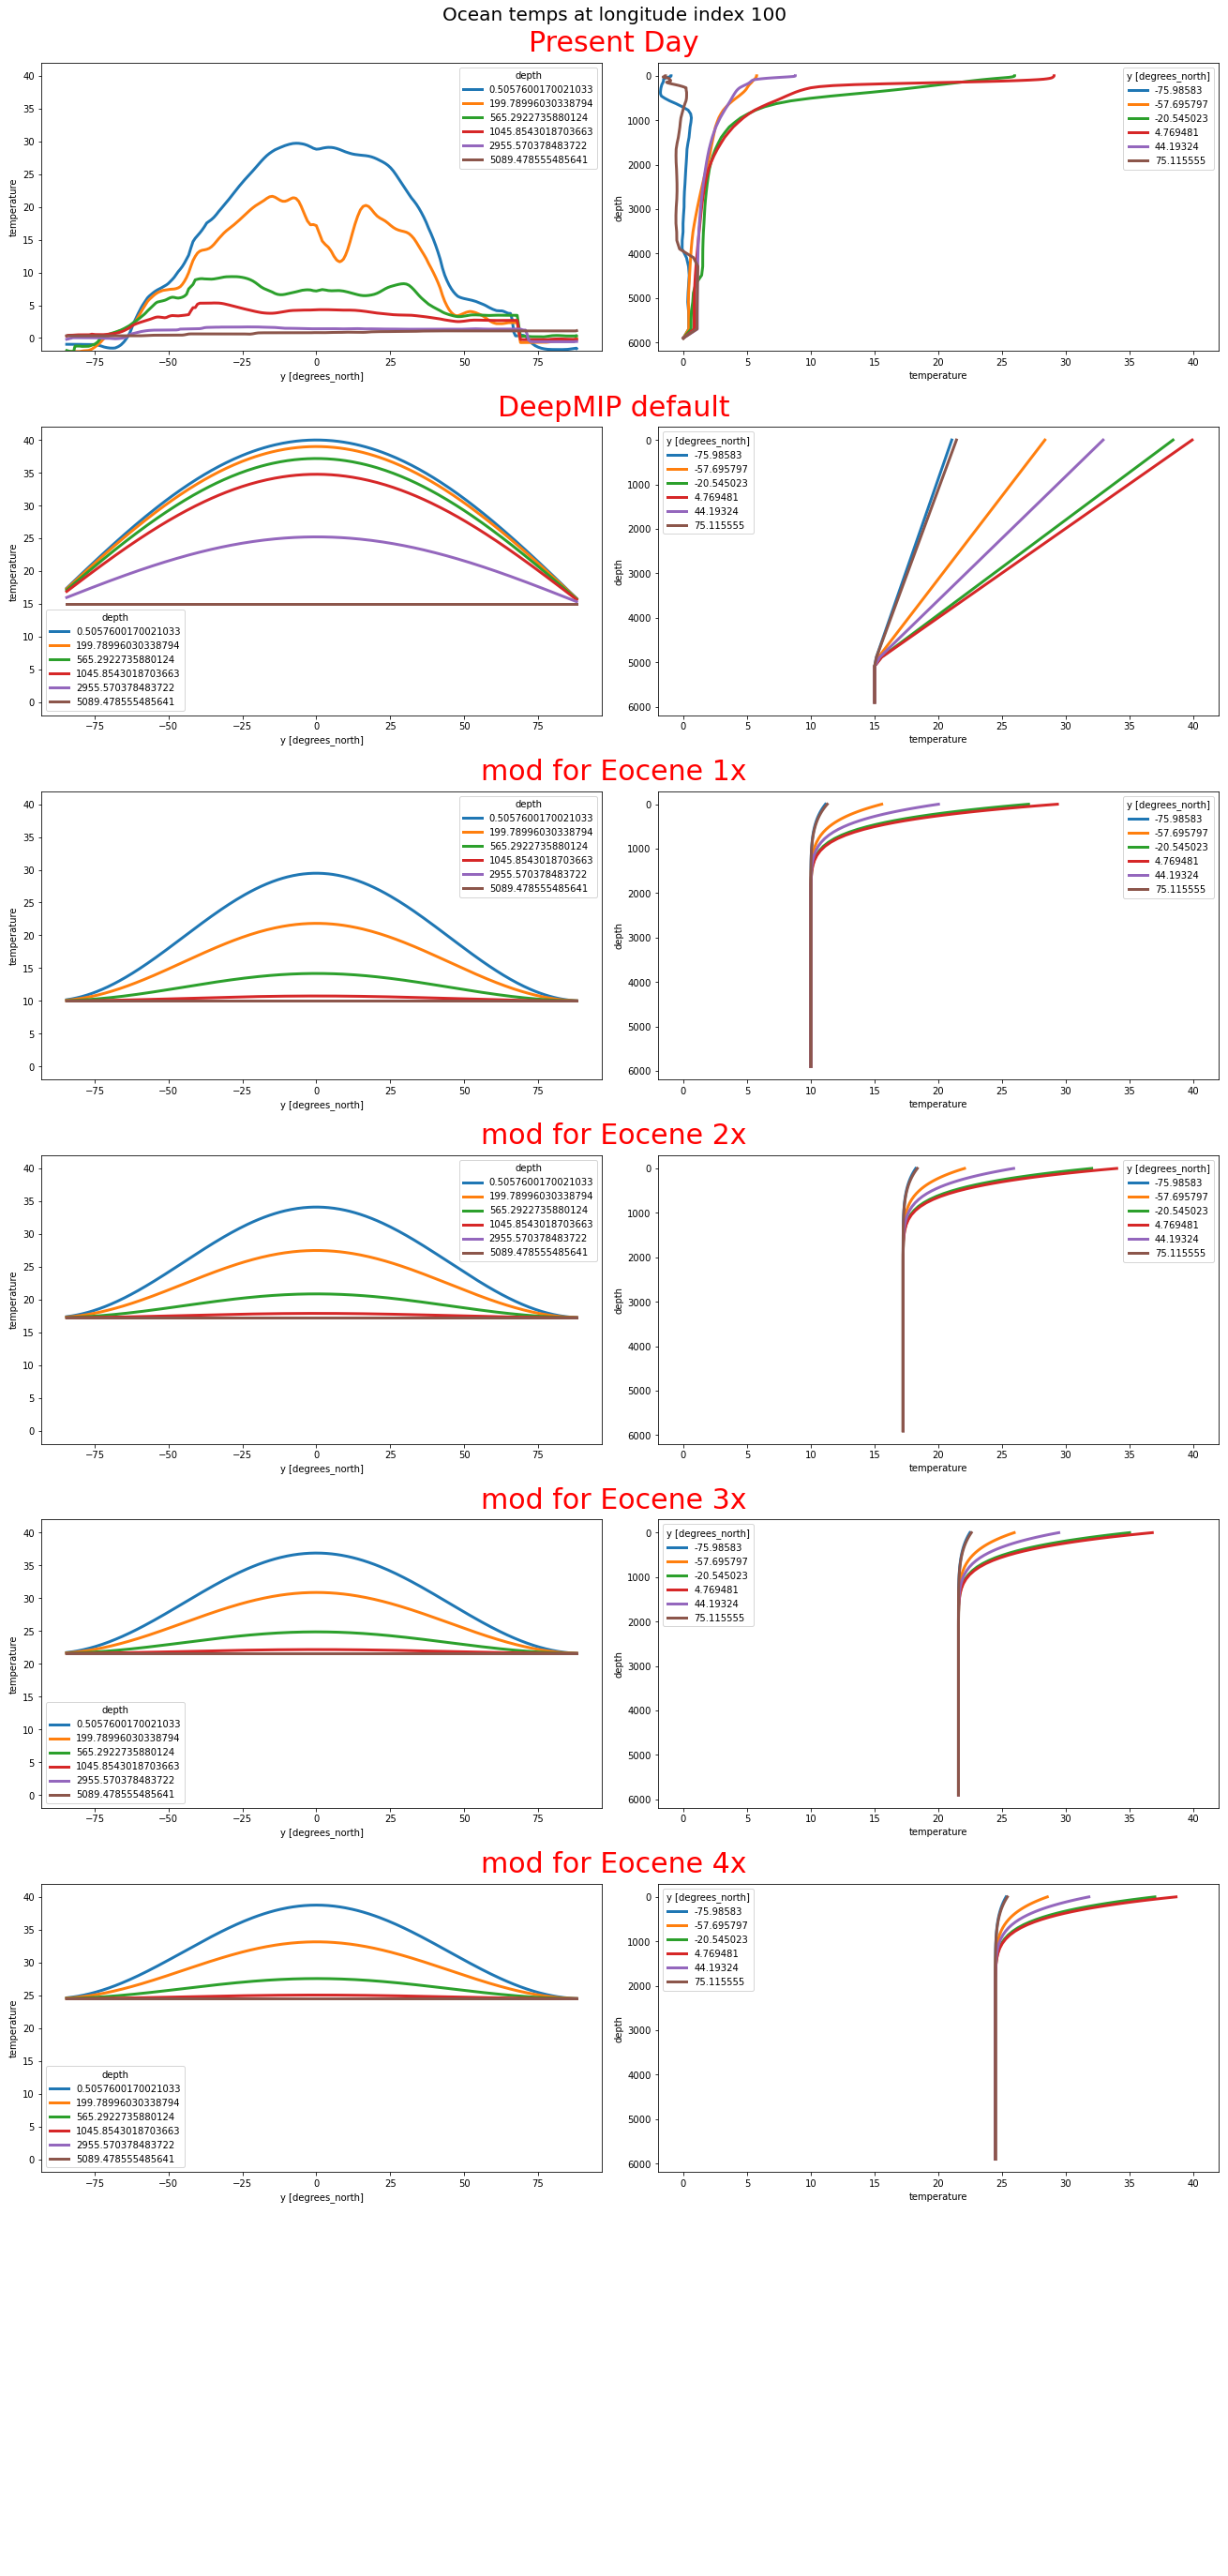

In [15]:
# plot of new T climatology at a single longitude index (to avoid averaging on curvilinear grid)
fig = plt.figure(constrained_layout=True, figsize=(18, 38))

(subfig1, subfig2, subfig3, subfig4, subfig5, subfig6, subfig7) = fig.subfigures(7, 1)
(ax1, ax2) = subfig1.subplots(1, 2)       # create 1x2 subplots on subfig1
(ax3, ax4) = subfig2.subplots(1, 2)       # create 1x2 subplots on subfig2
(ax5, ax6) = subfig3.subplots(1, 2)       # create 1x2 subplots on subfig3
(ax7, ax8) = subfig4.subplots(1, 2)       # create 1x2 subplots on subfig3
(ax9, ax10) = subfig5.subplots(1, 2)       # create 1x2 subplots on subfig3
(ax11, ax12) = subfig6.subplots(1, 2)       # create 1x2 subplots on subfig3

# set latitudes for example longitude 
TS_old_plot = TS_old.copy()
TS_gmd_plot = TS_gmd.copy()
TS_eocene1x_plot = TS_eocene1x.copy()
TS_eocene2x_plot = TS_eocene2x.copy()
TS_eocene3x_plot = TS_eocene3x.copy()
TS_eocene4x_plot = TS_eocene4x.copy()
TS_old_plot['y'] = TS_old_plot['nav_lat'][:,100]
TS_gmd_plot['y'] = TS_gmd_plot['nav_lat'][:,100]
TS_eocene1x_plot['y'] = TS_eocene1x_plot['nav_lat'][:,100]
TS_eocene2x_plot['y'] = TS_eocene2x_plot['nav_lat'][:,100]
TS_eocene3x_plot['y'] = TS_eocene3x_plot['nav_lat'][:,100]
TS_eocene4x_plot['y'] = TS_eocene4x_plot['nav_lat'][:,100]

subfig1.suptitle('Present Day', color='r', fontsize=30)               # set suptitle for subfig1
TS_old_plot['temperature'].isel(depth=[0,30,40,46,59,70], x=100).mean(dim=['time']).plot.line(ax = ax1, hue='depth', ylim=[-2,42], linewidth=3)
TS_old_plot['temperature'].isel(y=[50,100,150,200,250,300], x=100).mean(dim=['time']).plot.line(ax = ax2, hue='y', y='depth', xlim=[-2,42], linewidth=3)
ax2.invert_yaxis()
    
subfig2.suptitle('DeepMIP default', color='r', fontsize=30)    # set suptitle for subfig2
TS_gmd_plot['temperature'].isel(depth=[0,30,40,46,59,70], x=100).mean(dim=['time']).plot.line(ax = ax3, hue='depth', ylim=[-2,42], linewidth=3)
TS_gmd_plot['temperature'].isel(y=[50,100,150,200,250,300], x=100).mean(dim=['time']).plot.line(ax = ax4, hue='y', y='depth', xlim=[-2,42], linewidth=3)
ax4.invert_yaxis()

subfig3.suptitle('mod for Eocene 1x', color='r', fontsize=30)    # set suptitle for subfig4
TS_eocene1x_plot['temperature'].isel(depth=[0,30,40,46,59,70], x=100).mean(dim=['time']).plot.line(ax = ax5, hue='depth', ylim=[-2,42], linewidth=3)
TS_eocene1x_plot['temperature'].isel(y=[50,100,150,200,250,300], x=100).mean(dim=['time']).plot.line(ax = ax6, hue='y', y='depth', xlim=[-2,42], linewidth=3)
ax6.invert_yaxis()

subfig4.suptitle('mod for Eocene 2x', color='r', fontsize=30)    # set suptitle for subfig4
TS_eocene2x_plot['temperature'].isel(depth=[0,30,40,46,59,70], x=100).mean(dim=['time']).plot.line(ax = ax7, hue='depth', ylim=[-2,42], linewidth=3)
TS_eocene2x_plot['temperature'].isel(y=[50,100,150,200,250,300], x=100).mean(dim=['time']).plot.line(ax = ax8, hue='y', y='depth', xlim=[-2,42], linewidth=3)
ax8.invert_yaxis()

subfig5.suptitle('mod for Eocene 3x', color='r', fontsize=30)    # set suptitle for subfig4
TS_eocene3x_plot['temperature'].isel(depth=[0,30,40,46,59,70], x=100).mean(dim=['time']).plot.line(ax = ax9, hue='depth', ylim=[-2,42], linewidth=3)
TS_eocene3x_plot['temperature'].isel(y=[50,100,150,200,250,300], x=100).mean(dim=['time']).plot.line(ax = ax10, hue='y', y='depth', xlim=[-2,42], linewidth=3)
ax10.invert_yaxis()

subfig6.suptitle('mod for Eocene 4x', color='r', fontsize=30)    # set suptitle for subfig4
TS_eocene4x_plot['temperature'].isel(depth=[0,30,40,46,59,70], x=100).mean(dim=['time']).plot.line(ax = ax11, hue='depth', ylim=[-2,42], linewidth=3)
TS_eocene4x_plot['temperature'].isel(y=[50,100,150,200,250,300], x=100).mean(dim=['time']).plot.line(ax = ax12, hue='y', y='depth', xlim=[-2,42], linewidth=3)
ax12.invert_yaxis()

fig.suptitle('Ocean temps at longitude index 100', fontsize=20)

plt.savefig(outputDir + '/Eocene_initial_ocean_TS_v2.pdf', format='pdf')


In [12]:
# write new T+S climatologies to disk

# prevent default '_FillValue'
encoding = {'depth': {'zlib': False, '_FillValue': None},
            'time': {'zlib': False, '_FillValue': None, 'dtype': 'float32'},
            'nav_lon': {'zlib': False, '_FillValue': None, 'dtype': 'float32'},
            'nav_lat': {'zlib': False, '_FillValue': None, 'dtype': 'float32'},
            }

# Copy old grid coordinates
TS_gmd['nav_lon'] = TS_old['nav_lon'].copy()
TS_gmd['nav_lat'] = TS_old['nav_lat'].copy()
TS_eocene1x['nav_lon'] = TS_old['nav_lon'].copy()
TS_eocene1x['nav_lat'] = TS_old['nav_lat'].copy()
TS_eocene2x['nav_lon'] = TS_old['nav_lon'].copy()
TS_eocene2x['nav_lat'] = TS_old['nav_lat'].copy()
TS_eocene3x['nav_lon'] = TS_old['nav_lon'].copy()
TS_eocene3x['nav_lat'] = TS_old['nav_lat'].copy()
TS_eocene4x['nav_lon'] = TS_old['nav_lon'].copy()
TS_eocene4x['nav_lat'] = TS_old['nav_lat'].copy()

# write file
TS_gmd.to_netcdf(outputDir + '/TS_monthlymean_eORCA1T_NEMO_L75.GMD.nc', encoding=encoding) 
TS_eocene1x.to_netcdf(outputDir + '/TS_monthlymean_eORCA1T_NEMO_L75.eocene1x.nc', encoding=encoding) 
TS_eocene2x.to_netcdf(outputDir + '/TS_monthlymean_eORCA1T_NEMO_L75.eocene2x.nc', encoding=encoding) 
TS_eocene3x.to_netcdf(outputDir + '/TS_monthlymean_eORCA1T_NEMO_L75.eocene3x.nc', encoding=encoding) 
TS_eocene4x.to_netcdf(outputDir + '/TS_monthlymean_eORCA1T_NEMO_L75.eocene4x.nc', encoding=encoding) 
